In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
from sklearn.preprocessing import OneHotEncoder,LabelEncoder
from xgboost import XGBClassifier
from sklearn.grid_search import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.model_selection import KFold,cross_val_score
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

C:\ProgramData\Anaconda2\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\sklearn\grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [2]:
CSS = """
body {
    margin: 0;
    font-family: Helvetica;
}
table.dataframe {
    border-collapse: collapse;
    border: none;
}
table.dataframe tr {
    border: none;
}
table.dataframe td, table.dataframe th {
    margin: 0;
    border: 1px solid white;
    padding-left: 0.25em;
    padding-right: 0.25em;
}
table.dataframe th:not(:empty) {
    background-color: #fec;
    text-align: left;
    font-weight: normal;
}
table.dataframe tr:nth-child(2) th:empty {
    border-left: none;
    border-right: 1px dashed #888;
}
table.dataframe td {
    border: 2px solid #ccf;
    background-color: #f4f4ff;
}
"""

In [3]:
## Magics and commom settings
pd.set_option('display.float_format', lambda x: '%.4f' % x)
%matplotlib inline

pd.set_option("display.max_columns",7)

from IPython.core.display import HTML
HTML('<style>{}</style>'.format(CSS))

## Reading data

The data provided by Kaggle is comprised of 8 CSV files, with a main train/test file with reference to all the other files through the SK_xxx columns. The file *"HomeCredit_columns_description.csv"* contains information about each column in each file.

In [4]:
!dir data

 O volume na unidade C não tem nome.
 O Número de Série do Volume é D8D6-4768

 Pasta de C:\Users\braian.dias\datascience\machine-learning\projects\capstone\home_credit\data

28/08/2018  15:10    <DIR>          .
28/08/2018  15:10    <DIR>          ..
13/08/2018  17:06        26.567.651 application_test.csv
13/08/2018  17:06       166.133.370 application_train.csv
13/08/2018  17:06       170.016.717 bureau.csv
13/08/2018  17:06       375.592.889 bureau_balance.csv
13/08/2018  17:06       424.582.605 credit_card_balance.csv
28/08/2018  15:10           172.475 exploratory_analysis.twb
13/08/2018  17:06            37.383 HomeCredit_columns_description.csv
13/08/2018  17:05       723.118.349 installments_payments.csv
13/08/2018  17:06       392.703.158 POS_CASH_balance.csv
13/08/2018  17:06       404.973.293 previous_application.csv
13/08/2018  17:06           536.202 sample_submission.csv
              11 arquivo(s)  2.684.434.092 bytes
               2 pasta(s)   176.783.536.128 bytes di

In [5]:
# READ all .csv files
app_test = pd.read_csv("data/application_test.csv")
app_train = pd.read_csv("data/application_train.csv")
#bureau = pd.read_csv("data/bureau.csv")
#bureau_balance = pd.read_csv("data/bureau_balance.csv")
#previous_application = pd.read_csv("data/previous_application.csv")
#POS_CASH_balance = pd.read_csv("data/POS_CASH_balance.csv")
#credit_card_balance = pd.read_csv("data/credit_card_balance.csv")
#installments_payments = pd.read_csv("data/installments_payments.csv")

In [6]:
# Create a new dataframe containing basic stats about each file
cols = ["file_name","columns","rows"]
file_stats = pd.DataFrame(columns = cols)
file_stats = pd.concat([file_stats,pd.DataFrame(np.array([["application_train.csv",app_train.shape[1],app_train.shape[0]]]),columns=cols)])
file_stats = pd.concat([file_stats,pd.DataFrame(np.array([["application_test.csv",app_test.shape[1],app_test.shape[0]]]),columns=cols)])
file_stats = pd.concat([file_stats,pd.DataFrame(np.array([["bureau.csv",bureau.shape[1],bureau.shape[0]]]),columns=cols)])
file_stats = pd.concat([file_stats,pd.DataFrame(np.array([["bureau_balance.csv",bureau_balance.shape[1],bureau_balance.shape[0]]]),columns=cols)])
file_stats = pd.concat([file_stats,pd.DataFrame(np.array([["credit_card_balance.csv",credit_card_balance.shape[1],credit_card_balance.shape[0]]]),columns=cols)])
file_stats = pd.concat([file_stats,pd.DataFrame(np.array([["installments_payments.csv",installments_payments.shape[1],installments_payments.shape[0]]]),columns=cols)])
file_stats = pd.concat([file_stats,pd.DataFrame(np.array([["POS_CASH_balance.csv",POS_CASH_balance.shape[1],POS_CASH_balance.shape[0]]]),columns=cols)])
file_stats = pd.concat([file_stats,pd.DataFrame(np.array([["previous_application.csv",previous_application.shape[1],previous_application.shape[0]]]),columns=cols)])
file_stats = file_stats.reset_index(drop=True)

NameError: name 'bureau' is not defined

In [6]:
#Set dataframes to None to free memory after we have calculated the basic statistics for all files
POS_CASH_balance = None
credit_card_balance = None
installments_payments = None
previous_application = None
bureau = None
bureau_balance = None

#file_stats.to_csv("file_stats.csv",index=False)
file_stats = pd.read_csv("file_stats.csv")

Below is a summary of all 8 files available : 1 main file for training (with target) 1 main file for testing (without the target), and 6 other files containing additional information about each loan.

In [7]:
file_stats

,file_name,columns,rows
0,application_train.csv,122,307511
1,application_test.csv,121,48744
2,bureau.csv,17,1716428
3,bureau_balance.csv,3,27299925
4,credit_card_balance.csv,23,3840312
5,installments_payments.csv,8,13605401
6,POS_CASH_balance.csv,8,10001358
7,previous_application.csv,37,1670214


The training data has 307511 observations (each one a separate loan) and 122 features (variables) including the TARGET (the label we want to predict).
The test data folows the same structure, but it has 48744 observations and lacks the TARGET column.

We can see the first 5 observations of the main training data below :

In [6]:
app_train.head(10)

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,...,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,...,0.0000,0.0000,1.0000
1,100003,0,Cash loans,...,0.0000,0.0000,0.0000
2,100004,0,Revolving loans,...,0.0000,0.0000,0.0000
3,100006,0,Cash loans,...,nan,nan,nan
4,100007,0,Cash loans,...,0.0000,0.0000,0.0000
5,100008,0,Cash loans,...,0.0000,1.0000,1.0000
6,100009,0,Cash loans,...,1.0000,1.0000,2.0000
7,100010,0,Cash loans,...,0.0000,0.0000,0.0000
8,100011,0,Cash loans,...,0.0000,0.0000,1.0000
9,100012,0,Revolving loans,...,nan,nan,nan


It's possible to see that the two first columns are a identifier column (key) and the target variable, respectivelly. From now on those two columns will be removed from the analysis.

In [7]:
features = app_train.columns[2:]

## Dataset description and statistics 

### Distribution of target data

It seems that data is skewed, we have much more label 0 than label 1

Number of training instances with TARGET 0 : 282686
Number of training instances with TARGET 1 : 24825


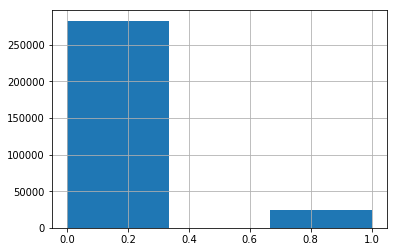

In [8]:
app_train['TARGET'].hist(bins=3)

print('Number of training instances with TARGET 0 : {}'.format(app_train[app_train['TARGET']<=0].shape[0]))
print('Number of training instances with TARGET 1 : {}'.format(app_train[app_train['TARGET']>0].shape[0]))

* Separating the features in the main file in **numerical** and **non-numerical** features in order to calculate statistics about the data 

In [9]:
non_numerical_features = [col for col in app_train[features].columns if app_train[col].dtype == 'object']    
text_binary_features = []

numerical_features     = [col for col in app_train[features].columns if app_train[col].dtype != 'object']
#Breaking numerical features into int and float
int_features     = [col for col in app_train[numerical_features].columns if app_train[col].dtype == 'int64']
int_binary_features = []    
float_features   = [col for col in app_train[numerical_features].columns if app_train[col].dtype != 'int64']

print("There are {} NON-numerical features in the main dataset.".format(len(non_numerical_features)))
print("There are {} numerical features in the main dataset.".format(len(numerical_features)))
print("\t{} are Int64 features".format(len(int_features)))
print("\t{} are Float64 features".format(len(float_features)))

There are 16 NON-numerical features in the main dataset.
There are 104 numerical features in the main dataset.
	39 are Int64 features
	65 are Float64 features


### Numerical features


In [10]:
print("List of Int64 features : {}".format(app_train[int_features].columns))
app_train[int_features].describe()

List of Int64 features : Index([u'CNT_CHILDREN', u'DAYS_BIRTH', u'DAYS_EMPLOYED', u'DAYS_ID_PUBLISH',
       u'FLAG_MOBIL', u'FLAG_EMP_PHONE', u'FLAG_WORK_PHONE',
       u'FLAG_CONT_MOBILE', u'FLAG_PHONE', u'FLAG_EMAIL',
       u'REGION_RATING_CLIENT', u'REGION_RATING_CLIENT_W_CITY',
       u'HOUR_APPR_PROCESS_START', u'REG_REGION_NOT_LIVE_REGION',
       u'REG_REGION_NOT_WORK_REGION', u'LIVE_REGION_NOT_WORK_REGION',
       u'REG_CITY_NOT_LIVE_CITY', u'REG_CITY_NOT_WORK_CITY',
       u'LIVE_CITY_NOT_WORK_CITY', u'FLAG_DOCUMENT_2', u'FLAG_DOCUMENT_3',
       u'FLAG_DOCUMENT_4', u'FLAG_DOCUMENT_5', u'FLAG_DOCUMENT_6',
       u'FLAG_DOCUMENT_7', u'FLAG_DOCUMENT_8', u'FLAG_DOCUMENT_9',
       u'FLAG_DOCUMENT_10', u'FLAG_DOCUMENT_11', u'FLAG_DOCUMENT_12',
       u'FLAG_DOCUMENT_13', u'FLAG_DOCUMENT_14', u'FLAG_DOCUMENT_15',
       u'FLAG_DOCUMENT_16', u'FLAG_DOCUMENT_17', u'FLAG_DOCUMENT_18',
       u'FLAG_DOCUMENT_19', u'FLAG_DOCUMENT_20', u'FLAG_DOCUMENT_21'],
      dtype='object')


,CNT_CHILDREN,DAYS_BIRTH,DAYS_EMPLOYED,...,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21
count,307511.0000,307511.0000,307511.0000,...,307511.0000,307511.0000,307511.0000
mean,0.4171,-16036.9951,63815.0459,...,0.0006,0.0005,0.0003
std,0.7221,4363.9886,141275.7665,...,0.0244,0.0225,0.0183
min,0.0000,-25229.0000,-17912.0000,...,0.0000,0.0000,0.0000
25%,0.0000,-19682.0000,-2760.0000,...,0.0000,0.0000,0.0000
50%,0.0000,-15750.0000,-1213.0000,...,0.0000,0.0000,0.0000
75%,1.0000,-12413.0000,-289.0000,...,0.0000,0.0000,0.0000
max,19.0000,-7489.0000,365243.0000,...,1.0000,1.0000,1.0000


There are some categorical features (e.g: FLAG_xxx features are binary features) that are coded as 0 and 1 (Int64) but in fact they are categorical. We're going to remove them from the numerical features and store in another variable called *int_binary_features*.

In [11]:
int_binary_features = ['FLAG_MOBIL', 'FLAG_EMP_PHONE', 'FLAG_WORK_PHONE',
       'FLAG_CONT_MOBILE', 'FLAG_PHONE', 'FLAG_EMAIL', 'REG_REGION_NOT_LIVE_REGION',
       'REG_REGION_NOT_WORK_REGION', 'LIVE_REGION_NOT_WORK_REGION',
       'REG_CITY_NOT_LIVE_CITY', 'REG_CITY_NOT_WORK_CITY',
       'LIVE_CITY_NOT_WORK_CITY', 'FLAG_DOCUMENT_2', 'FLAG_DOCUMENT_3',
       'FLAG_DOCUMENT_4', 'FLAG_DOCUMENT_5', 'FLAG_DOCUMENT_6',
       'FLAG_DOCUMENT_7', 'FLAG_DOCUMENT_8', 'FLAG_DOCUMENT_9',
       'FLAG_DOCUMENT_10', 'FLAG_DOCUMENT_11', 'FLAG_DOCUMENT_12',
       'FLAG_DOCUMENT_13', 'FLAG_DOCUMENT_14', 'FLAG_DOCUMENT_15',
       'FLAG_DOCUMENT_16', 'FLAG_DOCUMENT_17', 'FLAG_DOCUMENT_18',
       'FLAG_DOCUMENT_19', 'FLAG_DOCUMENT_20', 'FLAG_DOCUMENT_21']

int_features = [col for col in int_features if col not in int_binary_features]
numerical_features = [col for col in numerical_features if col not in int_binary_features]

In [12]:
print("List of Float64 features : {}".format(app_train[float_features].columns))
app_train[float_features].describe()

List of Float64 features : Index([u'AMT_INCOME_TOTAL', u'AMT_CREDIT', u'AMT_ANNUITY', u'AMT_GOODS_PRICE',
       u'REGION_POPULATION_RELATIVE', u'DAYS_REGISTRATION', u'OWN_CAR_AGE',
       u'CNT_FAM_MEMBERS', u'EXT_SOURCE_1', u'EXT_SOURCE_2', u'EXT_SOURCE_3',
       u'APARTMENTS_AVG', u'BASEMENTAREA_AVG', u'YEARS_BEGINEXPLUATATION_AVG',
       u'YEARS_BUILD_AVG', u'COMMONAREA_AVG', u'ELEVATORS_AVG',
       u'ENTRANCES_AVG', u'FLOORSMAX_AVG', u'FLOORSMIN_AVG', u'LANDAREA_AVG',
       u'LIVINGAPARTMENTS_AVG', u'LIVINGAREA_AVG', u'NONLIVINGAPARTMENTS_AVG',
       u'NONLIVINGAREA_AVG', u'APARTMENTS_MODE', u'BASEMENTAREA_MODE',
       u'YEARS_BEGINEXPLUATATION_MODE', u'YEARS_BUILD_MODE',
       u'COMMONAREA_MODE', u'ELEVATORS_MODE', u'ENTRANCES_MODE',
       u'FLOORSMAX_MODE', u'FLOORSMIN_MODE', u'LANDAREA_MODE',
       u'LIVINGAPARTMENTS_MODE', u'LIVINGAREA_MODE',
       u'NONLIVINGAPARTMENTS_MODE', u'NONLIVINGAREA_MODE', u'APARTMENTS_MEDI',
       u'BASEMENTAREA_MEDI', u'YEARS_BEGINEXPLUA

,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
count,307511.0000,307511.0000,307499.0000,...,265992.0000,265992.0000,265992.0000
mean,168797.9193,599025.9997,27108.5739,...,0.2674,0.2655,1.9000
std,237123.1463,402490.7770,14493.7373,...,0.9160,0.7941,1.8693
min,25650.0000,45000.0000,1615.5000,...,0.0000,0.0000,0.0000
25%,112500.0000,270000.0000,16524.0000,...,0.0000,0.0000,0.0000
50%,147150.0000,513531.0000,24903.0000,...,0.0000,0.0000,1.0000
75%,202500.0000,808650.0000,34596.0000,...,0.0000,0.0000,3.0000
max,117000000.0000,4050000.0000,258025.5000,...,27.0000,261.0000,25.0000


### percentage of null (NaN) among numerical variables

In [13]:
def null_count(dataframe):
    null = dataframe.isnull().sum()
    
    columns = null.index.values
    null_count = null.values
    null_stats = pd.DataFrame({'column' : columns, 'null_count': null_count})
    null_stats['total_rows'] = dataframe.shape[0]
    null_stats['perc_null'] = (null_stats['null_count'] / null_stats['total_rows']) * 100
    null_stats = null_stats[null_stats['null_count']> 0]
    null_stats = null_stats.sort_values(by=['null_count'],ascending=False)
    
    return null_stats

Number of features (numerical) with missing values : 61


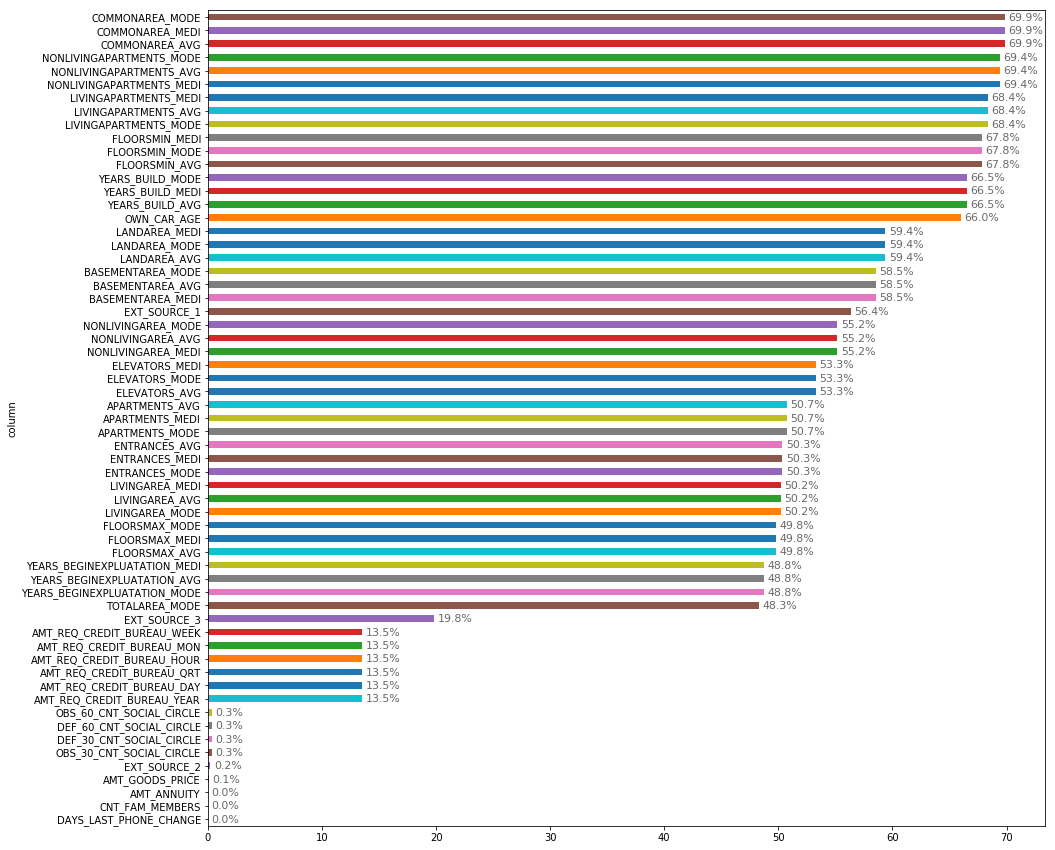

In [14]:
null_numerical = null_count(app_train[numerical_features])
print 'Number of features (numerical) with missing values : {}'.format(null_numerical.shape[0])
null_numerical.head(10)

null_numerical = null_numerical.sort_values(by="perc_null")
null_numerical = null_numerical.reset_index(drop=True)

ax = null_numerical.plot(kind="barh",x="column",y="perc_null",figsize=(15,15),legend=False)
for i,patch in enumerate(ax.patches):
    # get_width pulls left or right; get_y pushes up or down
    ax.text(patch.get_width()+.3, patch.get_y(), \
            str(round(null_numerical.loc[i,"perc_null"],1))+'%', fontsize=11,
color='dimgrey')

In [15]:
null_int_binary = null_count(app_train[int_binary_features])
null_int_binary

,column,null_count,total_rows,perc_null


It seems boolean data coded in (0,1) is complete :).

### Non-numerical features


In [16]:
print("There are {} non-numerical features : {}".format(len(non_numerical_features),app_train[non_numerical_features].columns))
app_train[non_numerical_features].describe()

There are 16 non-numerical features : Index([u'NAME_CONTRACT_TYPE', u'CODE_GENDER', u'FLAG_OWN_CAR',
       u'FLAG_OWN_REALTY', u'NAME_TYPE_SUITE', u'NAME_INCOME_TYPE',
       u'NAME_EDUCATION_TYPE', u'NAME_FAMILY_STATUS', u'NAME_HOUSING_TYPE',
       u'OCCUPATION_TYPE', u'WEEKDAY_APPR_PROCESS_START', u'ORGANIZATION_TYPE',
       u'FONDKAPREMONT_MODE', u'HOUSETYPE_MODE', u'WALLSMATERIAL_MODE',
       u'EMERGENCYSTATE_MODE'],
      dtype='object')


,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,...,HOUSETYPE_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE
count,307511,307511,307511,...,153214,151170,161756
unique,2,3,2,...,3,7,2
top,Cash loans,F,N,...,block of flats,Panel,No
freq,278232,202448,202924,...,150503,66040,159428


In [17]:
null_non_numerical = null_count(app_train[non_numerical_features])
null_non_numerical

,column,null_count,total_rows,perc_null
12,FONDKAPREMONT_MODE,210295,307511,68.3862
14,WALLSMATERIAL_MODE,156341,307511,50.8408
13,HOUSETYPE_MODE,154297,307511,50.1761
15,EMERGENCYSTATE_MODE,145755,307511,47.3983
9,OCCUPATION_TYPE,96391,307511,31.3455
4,NAME_TYPE_SUITE,1292,307511,0.4201


In [18]:
# fig, ax = plt.subplots(nrows=2, ncols=3,figsize=(15,15))
# feat_to_plot = null_non_numerical["column"].values
# feat_i = 0

# for row in ax:
#     for col in row:  
#         sns.countplot(x=feat_to_plot[feat_i], data=app_train,ax=col)
#         for label in col.get_xticklabels():
#             label.set_rotation(90)

#         feat_i +=1
        
# plt.show()

### binary variables

We can see from the data above that the features EMERGENCYSTATE_MODE has only two possible values (yes/no). However, we're going to treat it as it has more than 2 categories, once we're going to introduce a new category to represent the null values.

The list of binary features is defined below:

In [19]:
text_binary_features = ['NAME_CONTRACT_TYPE','FLAG_OWN_CAR','FLAG_OWN_REALTY']

non_numerical_features = [col for col in non_numerical_features if col not in text_binary_features]

Looking at the statistics above we start to see some aspects of the data that would be interesting to adjust:
* Some categorical features have too many levels (e.g: OCCUPATION_TYPE has 18, ORGANIZATION_TYPE has 58)
* Some of them have null data

In [20]:
corr_target = app_train.corr()["TARGET"]

In [21]:
top_corr = pd.DataFrame(corr_target.abs().sort_values(ascending=False).head(11))
top_corr

,TARGET
TARGET,1.0000
EXT_SOURCE_3,0.1789
EXT_SOURCE_2,0.1605
EXT_SOURCE_1,0.1553
DAYS_BIRTH,0.0782
REGION_RATING_CLIENT_W_CITY,0.0609
REGION_RATING_CLIENT,0.0589
DAYS_LAST_PHONE_CHANGE,0.0552
DAYS_ID_PUBLISH,0.0515
REG_CITY_NOT_WORK_CITY,0.0510


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000000001ED95DA0>,
      dtype=object)

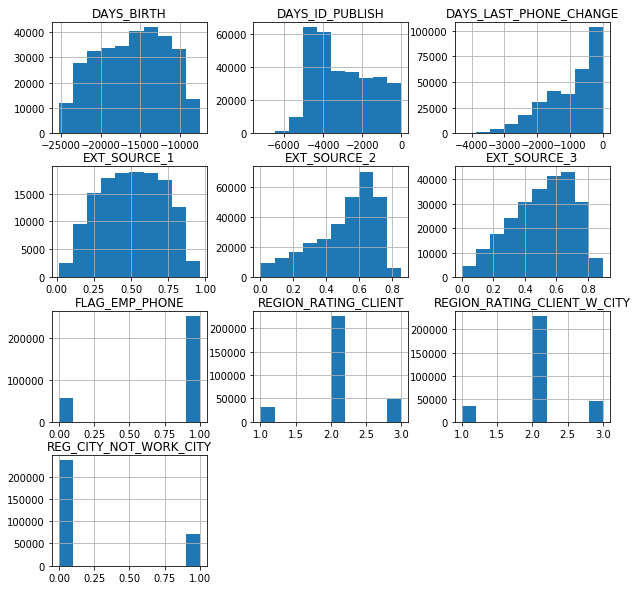

In [22]:
app_train[top_corr.index[1:]].hist(figsize=(10,10))

In [23]:
app_train['DAYS_BIRTH'].describe()

count   307511.0000
mean    -16036.9951
std       4363.9886
min     -25229.0000
25%     -19682.0000
50%     -15750.0000
75%     -12413.0000
max      -7489.0000
Name: DAYS_BIRTH, dtype: float64

## Data Preparation

### Label encoding for discrete features

For features with 2 or more levels, where going to perform one-hot encoding.
For binary features, we're going to perform label encoding.
But before that, null values will be placed in a new category called 'NOT_INF' (short for 'not informed').

In [24]:
#binary features
label_encoder = LabelEncoder()
for col in text_binary_features:
    label_encoder.fit(app_train[col])
    app_train[col] = label_encoder.transform(app_train[col])
    app_test[col] = label_encoder.transform(app_test[col])

In [25]:
#add NOT_INF to NaN values in categorical features
for feat in non_numerical_features:
    app_train.at[app_train[feat].isnull(),[feat]] = 'NOT_INF'
    app_test.at[app_test[feat].isnull(),[feat]] = 'NOT_INF'

In [26]:
#one-hot encoding for categorical features with more than 2 unique values
categorical_data_train = pd.get_dummies(app_train[non_numerical_features])
categorical_data_test  = pd.get_dummies(app_test[non_numerical_features])
one_hot_features = categorical_data_train.columns
app_train = pd.concat([app_train,categorical_data_train],axis=1)
app_test  = pd.concat([app_test,categorical_data_test],axis=1)
### remove the raw columns
app_train = app_train.drop(columns=non_numerical_features)
app_test  = app_test.drop(columns=non_numerical_features)

### data alignment

In [27]:
train_targets = app_train['TARGET']

# Align the training and testing data, keep only columns present in both dataframes
app_train, app_test = app_train.align(app_test, join = 'inner', axis = 1)

# Recover the target variable that was dropped during the alignment
app_train['TARGET'] = train_targets

In [28]:
features = app_train.columns[1:245].values

### Outliers

In [29]:
app_train['DAYS_EMPLOYED'].describe()

count   307511.0000
mean     63815.0459
std     141275.7665
min     -17912.0000
25%      -2760.0000
50%      -1213.0000
75%       -289.0000
max     365243.0000
Name: DAYS_EMPLOYED, dtype: float64

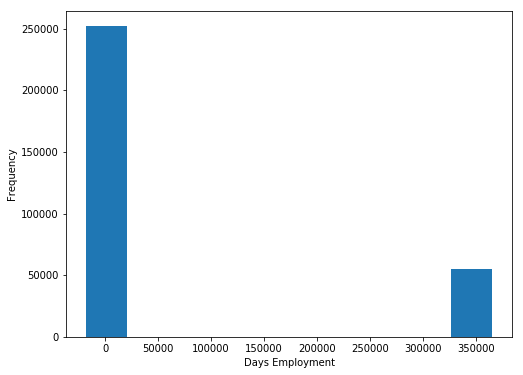

In [30]:
app_train['DAYS_EMPLOYED'].plot.hist(figsize=(8,6));
plt.xlabel('Days Employment');

In [31]:
anomaly = app_train[app_train['DAYS_EMPLOYED'] >= 300000]
print('There are %d anomalous days of employment' % len(anomaly))

There are 55374 anomalous days of employment


In [32]:
app_train['DAYS_EMPLOYED_OLD'] = app_train["DAYS_EMPLOYED"]

app_train['DAYS_EMPLOYED_OUTL'] = app_train["DAYS_EMPLOYED"] >= 300000
app_train.at[app_train['DAYS_EMPLOYED_OUTL']==True,'DAYS_EMPLOYED'] = np.nan

app_test['DAYS_EMPLOYED_OUTL'] = app_test["DAYS_EMPLOYED"] >= 300000
app_test.at[app_test['DAYS_EMPLOYED_OUTL']==True,'DAYS_EMPLOYED'] = np.nan

label_encoder = LabelEncoder()
label_encoder.fit(app_train['DAYS_EMPLOYED_OUTL'])
app_train['DAYS_EMPLOYED_OUTL'] = label_encoder.transform(app_train['DAYS_EMPLOYED_OUTL'])
app_test['DAYS_EMPLOYED_OUTL'] = label_encoder.transform(app_test['DAYS_EMPLOYED_OUTL'])



In [33]:
features = np.append(features,'DAYS_EMPLOYED_OUTL')

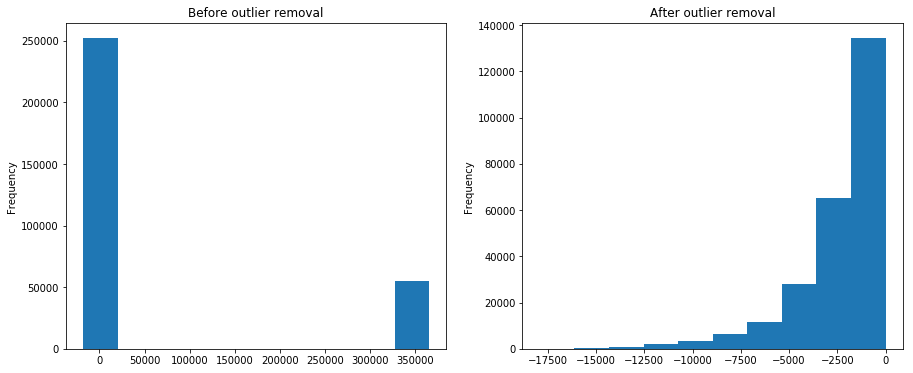

In [34]:
fig, ax = plt.subplots(nrows=1, ncols=2,figsize=(15,6))

app_train['DAYS_EMPLOYED_OLD'].plot.hist(ax=ax[0],title="Before outlier removal");
app_train['DAYS_EMPLOYED'].plot.hist(ax=ax[1],title="After outlier removal")


In [35]:
app_train = app_train.drop(columns=['DAYS_EMPLOYED_OLD'])

### Dealing with missing data

TODO : Explains why XGBoost can be a good candidate because it handles missing data.

TODO : How to train a base model (LogisticRegression/RandomForest) with missing data


In [36]:
app_train_no_null = app_train.copy()

null_feat = (features for features in numerical_features \
                 if app_train_no_null.loc[app_train_no_null[features].isnull(),[features]].shape[0]>0)
for feat in null_feat:
    app_train_no_null.at[app_train_no_null[feat].isnull(),[feat]] = np.nanmedian(app_train_no_null[feat])


In [37]:
app_test_no_null = app_test.copy()

null_feat = (features for features in numerical_features \
                 if app_test_no_null.loc[app_test_no_null[features].isnull(),[features]].shape[0]>0)
for feat in null_feat:
    app_test_no_null.at[app_test_no_null[feat].isnull(),[feat]] = np.nanmedian(app_test_no_null[feat])


In [67]:
def save_results_to_submit(predictions,id=[],filename=None):
    sk_id_curr = None
    if len(id)==0:
        sk_id_curr = app_test['SK_ID_CURR'].values
    else:
        sk_id_curr = id
        
    submission_result = pd.DataFrame({'SK_ID_CURR' : sk_id_curr ,'TARGET' : predictions})
    submission_result[submission_result['TARGET']==0]
    if filename != None:
        submission_result.to_csv(filename,index=False)
        print("predictions saved : {}".format(filename))
    print("Total predicted 0 : {}".format(submission_result.loc[submission_result['TARGET']==0,['TARGET']].count()[0]))
    print("Total predicted 1 : {}".format(submission_result.loc[submission_result['TARGET']==1,['TARGET']].count()[0]))

In [84]:
def train_test_classifier(train_df,features,clf,test_size=0.25):
    time_start = time.time()

    X = train_df[features]
    Y = train_df['TARGET']

    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = test_size,random_state = 50)
    clf.fit(X_train,y_train)

    prediction = clf.predict(X_test)
    #score = cross_val_score(base_model, X, Y, scoring='roc_auc', cv = 10)

    print('Model trained in {} seconds'.format(time.time()-time_start))
    #print('AUC of Random Forest is : {} '.format(np.mean(score)))
    print('Validation AUC score of {:.4f}.').format(roc_auc_score(y_true=y_test,y_score=prediction))
    
    return clf, X_train, X_test, y_train, y_test, prediction

### Training the baseline model

In [47]:
time_start = time.time()

X = app_train_no_null[features]
Y = app_train_no_null['TARGET']

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.25,random_state = 50)
base_model = RandomForestClassifier(random_state = 50)
base_model.fit(X_train,y_train)

pred_basemodel = base_model.predict(X_test)
#score = cross_val_score(base_model, X, Y, scoring='roc_auc', cv = 10)

print('RandomForest trained in {} seconds'.format(time.time()-time_start))
#print('AUC of Random Forest is : {} '.format(np.mean(score)))
print('Tuned model has a validation AUC score of {:.4f}.').format(roc_auc_score(y_true=y_test,y_score=pred_basemodel))

RandomForest trained in 14.510999918 seconds
Tuned model has a validation AUC score of 0.5040.


In [82]:
base_model = RandomForestClassifier(random_state = 50)
base_model, _, X_test, _, y_test, preds = train_test_classifier(app_train_no_null,features,base_model)

Model trained in 13.2139999866 seconds
Validation AUC score of 0.5040.


In [68]:
save_results_to_submit(pred_basemodel,y_test)

Total predicted 0 : 76699
Total predicted 1 : 179


In [ ]:
RandomForest trained in 152.924993038 seconds
AUC of Random Forest is : 0.629890706324 

### XGBOOST with NaN values

In [113]:
time_start = time.time()

X = app_train[features]
Y = app_train['TARGET']
xgboost_1 = XGBClassifier(random_state=50)
score = cross_val_score(xgboost_1, X, Y, scoring='roc_auc', cv = 10)

print('XGBoost trained in {} seconds'.format(time.time()-time_start))
print('AUC of XGBoost is : {} '.format(np.mean(score)))

XGBoost trained in 1590.18680191 seconds
AUC of XGBoost is : 0.751406734324 


In [85]:
xgboost_1 = XGBClassifier(random_state=50)
xgboost_1, _, X_test, _, y_test, preds_xgb = train_test_classifier(app_train,features,xgboost_1,test_size=0.1)

Model trained in 220.487999916 seconds
Validation AUC score of 0.5021.


C:\ProgramData\Anaconda2\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


### FINAL MODEL (XGBOOST) - no missing data

In [64]:
time_start = time.time()

X = app_train_no_null[features]
Y = app_train_no_null['TARGET']
final_model = XGBClassifier(random_state=50)
score = cross_val_score(final_model, X, Y, scoring='roc_auc', cv = 10)

print('XGBoost trained in {} seconds'.format(time.time()-time_start))
print('AUC of XGBoost is : {} '.format(np.mean(score)))

XGBoost trained in 1417.40337586 seconds
AUC of XGBoost is : 0.750407953192 


In [86]:
import gc
gc.collect()

221

### Optimization : Grid search

In [ ]:
time_start = time.time()

# Create hyperparameter options
parameters = {'max_depth': [None,10, 50],
              'min_samples_leaf': [1, 4],
              'n_estimators': [50, 100, 200]}

X = app_train_no_null[features]
Y = app_train_no_null['TARGET']
base_model = RandomForestClassifier(random_state=50)

grid_obj = GridSearchCV(estimator=base_model,
                        param_grid=parameters,
                        scoring='roc_auc',
                        verbose=10,
                        n_jobs=3)

grid_obj = grid_obj.fit(X, Y)

best_rf = grid_obj.best_estimator_
y_train_rf_opt = best_rf.predict(app_train_no_null[features])

print('Tuned model has a training AUC score of {:.4f}.').format(roc_auc_score(y_true=Y,y_score=y_train_rf_opt))
print('Grid search took {} seconds to run'.format(time.time()-time_start))

Fitting 3 folds for each of 18 candidates, totalling 54 fits
[CV] n_estimators=50, max_depth=None, min_samples_leaf=1 .............
[CV] n_estimators=50, max_depth=None, min_samples_leaf=1 .............
[CV] n_estimators=50, max_depth=None, min_samples_leaf=1 .............
[CV] n_estimators=100, max_depth=None, min_samples_leaf=1 ............
[CV] n_estimators=100, max_depth=None, min_samples_leaf=1 ............


Process PoolWorker-14:
Traceback (most recent call last):
  File "/home/braian/anaconda2/envs/ml/lib/python2.7/multiprocessing/process.py", line 267, in _bootstrap
    self.run()
  File "/home/braian/anaconda2/envs/ml/lib/python2.7/multiprocessing/process.py", line 114, in run
    self._target(*self._args, **self._kwargs)
  File "/home/braian/anaconda2/envs/ml/lib/python2.7/multiprocessing/pool.py", line 113, in worker
    result = (True, func(*args, **kwds))
KeyboardInterrupt


[CV] n_estimators=100, max_depth=None, min_samples_leaf=1 ............


Process PoolWorker-17:
Traceback (most recent call last):
  File "/home/braian/anaconda2/envs/ml/lib/python2.7/multiprocessing/process.py", line 267, in _bootstrap
    self.run()
Process PoolWorker-15:
  File "/home/braian/anaconda2/envs/ml/lib/python2.7/multiprocessing/process.py", line 114, in run
Traceback (most recent call last):
  File "/home/braian/anaconda2/envs/ml/lib/python2.7/multiprocessing/process.py", line 267, in _bootstrap
    self.run()
    self._target(*self._args, **self._kwargs)
  File "/home/braian/anaconda2/envs/ml/lib/python2.7/multiprocessing/pool.py", line 102, in worker
  File "/home/braian/anaconda2/envs/ml/lib/python2.7/multiprocessing/process.py", line 114, in run
    self._target(*self._args, **self._kwargs)
    task = get()
  File "/home/braian/anaconda2/envs/ml/lib/python2.7/multiprocessing/pool.py", line 102, in worker
    task = get()
  File "/home/braian/anaconda2/envs/ml/lib/python2.7/site-packages/sklearn/externals/joblib/pool.py", line 360, in get
 

KeyboardInterrupt
KeyboardInterrupt
    racquire()
KeyboardInterrupt
Process PoolWorker-31:
Process PoolWorker-30:
Process PoolWorker-29:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/braian/anaconda2/envs/ml/lib/python2.7/multiprocessing/process.py", line 267, in _bootstrap
  File "/home/braian/anaconda2/envs/ml/lib/python2.7/multiprocessing/process.py", line 267, in _bootstrap
  File "/home/braian/anaconda2/envs/ml/lib/python2.7/multiprocessing/process.py", line 267, in _bootstrap
    self.run()
  File "/home/braian/anaconda2/envs/ml/lib/python2.7/multiprocessing/process.py", line 114, in run
    self._target(*self._args, **self._kwargs)
    self.run()
  File "/home/braian/anaconda2/envs/ml/lib/python2.7/multiprocessing/process.py", line 114, in run
    self._target(*self._args, **self._kwargs)
  File "/home/braian/anaconda2/envs/ml/lib/python2.7/multiprocessing/pool.py", line 102, in worker
    task = get()
  F

In [47]:
grid_obj.best_params_
grid_obj.best_score_
predictions_best_rf = best_rf.predict(app_test_no_null[features])

In [48]:
predictions_best_rf

array([0, 0, 0, ..., 0, 0, 0])

In [88]:
param_test1 = {
 'max_depth':range(3,10,3),
 'min_child_weight':range(1,6,3),
 'gamma':[i/10.0 for i in range(0,5)]
}

time_start = time.time()

X = app_train[features]
Y = app_train['TARGET']
gsearch_xgb1 = GridSearchCV(estimator = XGBClassifier(learning_rate =0.1, n_estimators=200, \
                            subsample=0.8, colsample_bytree=0.8, objective= 'binary:logistic', \
                            nthread=4, scale_pos_weight=1, seed=50), 
                            param_grid = param_test1, scoring='roc_auc',n_jobs=3,iid=False, verbose=10)

gsearch_xgb1 = gsearch_xgb1.fit(X, Y)
best_xgb = gsearch_xgb1.best_estimator_
y_train_xgb_opt1 = best_xgb.predict(app_train[features])

print('Tuned model has a training AUC score of {:.4f}.').format(roc_auc_score(y_true=Y,y_score=y_train_xgb_opt1))
print('Grid search took {} seconds to run'.format(time.time()-time_start))

Fitting 3 folds for each of 30 candidates, totalling 90 fits


[Parallel(n_jobs=3)]: Done   2 tasks      | elapsed:  6.1min
[Parallel(n_jobs=3)]: Done   7 tasks      | elapsed: 22.4min
[Parallel(n_jobs=3)]: Done  12 tasks      | elapsed: 33.2min
[Parallel(n_jobs=3)]: Done  19 tasks      | elapsed: 70.7min
[Parallel(n_jobs=3)]: Done  26 tasks      | elapsed: 88.2min
[Parallel(n_jobs=3)]: Done  35 tasks      | elapsed: 133.6min
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed: 157.1min
[Parallel(n_jobs=3)]: Done  55 tasks      | elapsed: 206.7min
[Parallel(n_jobs=3)]: Done  66 tasks      | elapsed: 238.0min
[Parallel(n_jobs=3)]: Done  79 tasks      | elapsed: 293.5min


KeyboardInterrupt: 

In [44]:
predictions_best_xgb = best_xgb.predict(app_test[features])

/home/braian/anaconda2/envs/ml/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


result= pd.DataFrame(predictions_best_xgb)
result[result[0]==1]

XGBoostError: need to call fit or load_model beforehand

,SK_ID_CURR,TARGET
0,100001,0
1,100005,0
2,100013,0
3,100028,0
4,100038,0


### t-SNE for visualization - discarded

In [80]:
rndperm = np.random.permutation(app_train_no_null.shape[0]-1)

n_sne = 30000

tsne = TSNE(random_state=42, verbose=1)
tsne_results = tsne.fit_transform(app_train_no_null.loc[rndperm[:n_sne],:])
#df_tsne = app_train_no_null[rndperm[:n_sne],:].copy()
df_tsne = pd.DataFrame()
df_tsne['x-tsne'] = tsne_results[:,0]
df_tsne['y-tsne'] = tsne_results[:,1]
df_tsne['TARGET'] = app_train_no_null.loc[rndperm[:n_sne],'TARGET'].values

# Cria a figura
fig = plt.figure( figsize=(8,8) )
ax = fig.add_subplot(1, 1, 1, title='tSNE' )
# Cria o scatterplot
ax.scatter(
    x=df_tsne['x-tsne'], 
    y=df_tsne['y-tsne'], 
    c=df_tsne['TARGET'], 
    cmap=plt.cm.get_cmap('Paired'), 
    alpha=0.5)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 30000 samples in 0.406s...
[t-SNE] Computed neighbors for 30000 samples in 30.103s...
[t-SNE] Computed conditional probabilities for sample 1000 / 30000
[t-SNE] Computed conditional probabilities for sample 2000 / 30000
[t-SNE] Computed conditional probabilities for sample 3000 / 30000
[t-SNE] Computed conditional probabilities for sample 4000 / 30000
[t-SNE] Computed conditional probabilities for sample 5000 / 30000
[t-SNE] Computed conditional probabilities for sample 6000 / 30000
[t-SNE] Computed conditional probabilities for sample 7000 / 30000
[t-SNE] Computed conditional probabilities for sample 8000 / 30000
[t-SNE] Computed conditional probabilities for sample 9000 / 30000
[t-SNE] Computed conditional probabilities for sample 10000 / 30000
[t-SNE] Computed conditional probabilities for sample 11000 / 30000
[t-SNE] Computed conditional probabilities for sample 12000 / 30000
[t-SNE] Computed conditional probabilities for sa

In [96]:
print app_train_no_null.shape
print app_test_no_null.shape

(307511, 247)
(48744, 246)


In [ ]:
import datetime
print datetime.datetime.now().strftime("%Y-%m-%d %H:%M")

In [46]:
app_train_corr = app_train[features].corr()

In [47]:
count_high_correlate = 0
corr = pd.DataFrame(columns=['var_a', 'var_b', 'corr'])

for column in app_train_corr.columns:
    for idx,row in app_train_corr.iterrows():
        if (abs(row[column]) > 0.8) and row.name != column:
            if corr[(corr['var_a']==column) & (corr['var_b']==row.name)].shape[0]==0:
                corr = pd.concat([corr,pd.DataFrame({'var_a': [row.name], 'var_b': [column], 'corr': [row[column]]}) ])
                count_high_correlate += 1
                #print ' {} x {} = {}'.format(row.name,column,row[column])
            
print 'Total correlations > 0.8 : {}'.format(count_high_correlate)

/home/braian/anaconda2/envs/ml/lib/python2.7/site-packages/ipykernel_launcher.py:8: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  


Total correlations > 0.8 : 112


In [58]:
cols = np.unique(corr['var_a'].values + corr['var_b'].values)
cols

array(['AMT_GOODS_PRICEAMT_CREDIT', 'APARTMENTS_MEDIAPARTMENTS_AVG',
       'APARTMENTS_MEDIAPARTMENTS_MODE', 'APARTMENTS_MEDIELEVATORS_AVG',
       'APARTMENTS_MEDIELEVATORS_MODE',
       'APARTMENTS_MEDILIVINGAPARTMENTS_AVG',
       'APARTMENTS_MEDILIVINGAPARTMENTS_MODE',
       'APARTMENTS_MEDILIVINGAREA_AVG', 'APARTMENTS_MEDILIVINGAREA_MODE',
       'APARTMENTS_MODEAPARTMENTS_AVG', 'APARTMENTS_MODEELEVATORS_AVG',
       'APARTMENTS_MODELIVINGAPARTMENTS_AVG',
       'APARTMENTS_MODELIVINGAREA_AVG',
       'BASEMENTAREA_MEDIBASEMENTAREA_AVG',
       'BASEMENTAREA_MEDIBASEMENTAREA_MODE',
       'BASEMENTAREA_MODEBASEMENTAREA_AVG', 'CNT_FAM_MEMBERSCNT_CHILDREN',
       'COMMONAREA_MEDICOMMONAREA_AVG', 'COMMONAREA_MEDICOMMONAREA_MODE',
       'COMMONAREA_MODECOMMONAREA_AVG',
       'DEF_60_CNT_SOCIAL_CIRCLEDEF_30_CNT_SOCIAL_CIRCLE',
       'ELEVATORS_AVGAPARTMENTS_AVG', 'ELEVATORS_MEDIAPARTMENTS_AVG',
       'ELEVATORS_MEDIAPARTMENTS_MEDI', 'ELEVATORS_MEDIAPARTMENTS_MODE',
       'ELEVA

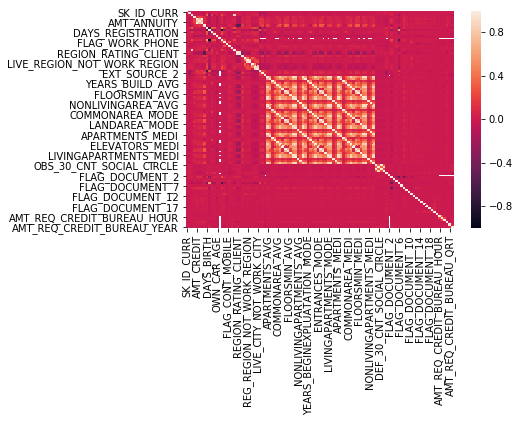

In [10]:
sns.heatmap(app_train_corr,vmin = -1, vmax=1,)

## Additional files

## bureau.csv

In [6]:
bureau.head()

,SK_ID_CURR,SK_ID_BUREAU,CREDIT_ACTIVE,CREDIT_CURRENCY,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,CREDIT_TYPE,DAYS_CREDIT_UPDATE,AMT_ANNUITY
0,215354,5714462,Closed,currency 1,-497,0,-153.0000,-153.0000,nan,0,91323.0000,0.0000,nan,0.0000,Consumer credit,-131,nan
1,215354,5714463,Active,currency 1,-208,0,1075.0000,nan,nan,0,225000.0000,171342.0000,nan,0.0000,Credit card,-20,nan
2,215354,5714464,Active,currency 1,-203,0,528.0000,nan,nan,0,464323.5000,nan,nan,0.0000,Consumer credit,-16,nan
3,215354,5714465,Active,currency 1,-203,0,nan,nan,nan,0,90000.0000,nan,nan,0.0000,Credit card,-16,nan
4,215354,5714466,Active,currency 1,-629,0,1197.0000,nan,77674.5000,0,2700000.0000,nan,nan,0.0000,Consumer credit,-21,nan


In [39]:
bureau_cont_feat = [col for col in bureau.columns[2:] if bureau[col].dtype in ['int64','float64']]
bureau_other_feat = [col for col in bureau.columns[2:] if bureau[col].dtype not in ['int64','float64']]
print bureau.columns
print '\nNumerical features : {}\n'.format(bureau_cont_feat)
print 'Categorical features : {}\n'.format(bureau_other_feat)

Index([u'SK_ID_CURR', u'SK_ID_BUREAU', u'CREDIT_ACTIVE', u'CREDIT_CURRENCY',
       u'DAYS_CREDIT', u'CREDIT_DAY_OVERDUE', u'DAYS_CREDIT_ENDDATE',
       u'DAYS_ENDDATE_FACT', u'AMT_CREDIT_MAX_OVERDUE', u'CNT_CREDIT_PROLONG',
       u'AMT_CREDIT_SUM', u'AMT_CREDIT_SUM_DEBT', u'AMT_CREDIT_SUM_LIMIT',
       u'AMT_CREDIT_SUM_OVERDUE', u'CREDIT_TYPE', u'DAYS_CREDIT_UPDATE',
       u'AMT_ANNUITY'],
      dtype='object')

Numerical features : ['DAYS_CREDIT', 'CREDIT_DAY_OVERDUE', 'DAYS_CREDIT_ENDDATE', 'DAYS_ENDDATE_FACT', 'AMT_CREDIT_MAX_OVERDUE', 'CNT_CREDIT_PROLONG', 'AMT_CREDIT_SUM', 'AMT_CREDIT_SUM_DEBT', 'AMT_CREDIT_SUM_LIMIT', 'AMT_CREDIT_SUM_OVERDUE', 'DAYS_CREDIT_UPDATE', 'AMT_ANNUITY']

Categorical features : ['CREDIT_ACTIVE', 'CREDIT_CURRENCY', 'CREDIT_TYPE']



In [10]:
print 'Total applications from bureau : {}'.format(len(bureau['SK_ID_CURR'].unique()))
print 'Total applications : {}'.format(len(app_train['SK_ID_CURR'].unique()))

Total applications from bureau : 305811
Total applications : 307511


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f6303dcfe50>,
      dtype=object)

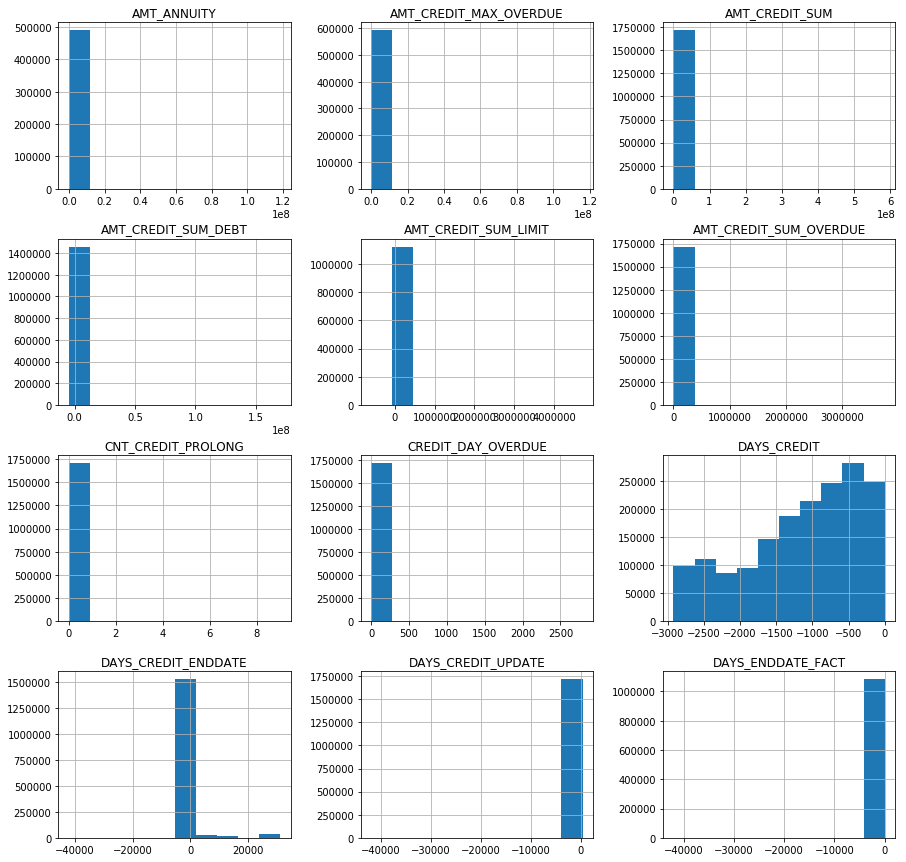

In [30]:
bureau[bureau_cont_feat].hist(figsize=(15,15))

In [36]:
bureau[bureau_other_feat].describe()

,CREDIT_ACTIVE,CREDIT_CURRENCY,CREDIT_TYPE
count,1716428,1716428,1716428
unique,4,4,15
top,Closed,currency 1,Consumer credit
freq,1079273,1715020,1251615


### bureau_balance.csv

In [41]:
print bureau_balance.shape
bureau_balance.head()

(27299925, 3)


,SK_ID_BUREAU,MONTHS_BALANCE,STATUS
0,5715448,0,C
1,5715448,-1,C
2,5715448,-2,C
3,5715448,-3,C
4,5715448,-4,C


count   27299925.0000
mean         -30.7417
std           23.8645
min          -96.0000
25%          -46.0000
50%          -25.0000
75%          -11.0000
max            0.0000
Name: MONTHS_BALANCE, dtype: float64

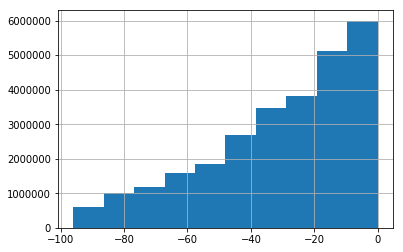

In [8]:
## Month of balance relative to application date (-1 means the freshest balance date)
bureau_balance['MONTHS_BALANCE'].hist()
bureau_balance['MONTHS_BALANCE'].describe()

### Status of Credit Bureau loan during the month :
* active, 
* closed, 
* DPD0-30 :
    * C means closed, 
    * X means status unknown, 
    * 0 means no DPD, 
    * 1 means maximal did during month between 1-30, 
    * 2 means DPD 31-60,
    * 5 means DPD 120+ or sold or written off

In [7]:
print bureau_balance['STATUS'].unique()
bureau_balance['STATUS'].describe()

['C' '0' 'X' '1' '2' '3' '5' '4']


count     27299925
unique           8
top              C
freq      13646993
Name: STATUS, dtype: object

In [11]:
loan_02 = bureau[bureau['SK_ID_CURR']==100002]

In [12]:
loan_02.sort_values(by=['DAYS_CREDIT'])

,SK_ID_CURR,SK_ID_BUREAU,CREDIT_ACTIVE,CREDIT_CURRENCY,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,CREDIT_TYPE,DAYS_CREDIT_UPDATE,AMT_ANNUITY
675686,100002,6158906,Closed,currency 1,-1437,0,-1072.0000,-1185.0000,0.0000,0,135000.0000,0.0000,0.0000,0.0000,Consumer credit,-1185,0.0000
675684,100002,6158904,Closed,currency 1,-1125,0,-1038.0000,-1038.0000,nan,0,40761.0000,nan,nan,0.0000,Credit card,-1038,0.0000
675687,100002,6158907,Closed,currency 1,-1121,0,-911.0000,-911.0000,3321.0000,0,19071.0000,nan,nan,0.0000,Consumer credit,-906,0.0000
1486113,100002,6113835,Closed,currency 1,-1043,0,62.0000,-967.0000,0.0000,0,67500.0000,nan,nan,0.0000,Credit card,-758,0.0000
1337779,100002,6158903,Active,currency 1,-1042,0,780.0000,nan,nan,0,450000.0000,245781.0000,0.0000,0.0000,Consumer credit,-7,0.0000
675688,100002,6158908,Closed,currency 1,-645,0,85.0000,-36.0000,5043.6450,0,120735.0000,0.0000,0.0000,0.0000,Consumer credit,-34,0.0000
675685,100002,6158905,Closed,currency 1,-476,0,nan,-48.0000,nan,0,0.0000,0.0000,nan,0.0000,Credit card,-47,nan
675689,100002,6158909,Active,currency 1,-103,0,nan,nan,40.5000,0,31988.5650,0.0000,31988.5650,0.0000,Credit card,-24,0.0000


In [11]:
loan2balance = bureau_balance[bureau_balance['SK_ID_BUREAU']==6158903]

In [12]:
loan2balance

,SK_ID_BUREAU,MONTHS_BALANCE,STATUS
19443472,6158903,-19,C
19443473,6158903,-20,C
19443474,6158903,-21,1
19443475,6158903,-22,1
19443476,6158903,-23,0
19443477,6158903,-24,1
19443478,6158903,-25,1
19443479,6158903,-26,X
19443480,6158903,-27,1
19443481,6158903,-28,1


### previous_application.csv

In [18]:
print previous_application.shape
previous_application.head()

(1670214, 37)


,SK_ID_PREV,SK_ID_CURR,NAME_CONTRACT_TYPE,AMT_ANNUITY,AMT_APPLICATION,AMT_CREDIT,AMT_DOWN_PAYMENT,AMT_GOODS_PRICE,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,...,NAME_SELLER_INDUSTRY,CNT_PAYMENT,NAME_YIELD_GROUP,PRODUCT_COMBINATION,DAYS_FIRST_DRAWING,DAYS_FIRST_DUE,DAYS_LAST_DUE_1ST_VERSION,DAYS_LAST_DUE,DAYS_TERMINATION,NFLAG_INSURED_ON_APPROVAL
0,2030495,271877,Consumer loans,1730.4300,17145.0000,17145.0000,0.0000,17145.0000,SATURDAY,15,...,Connectivity,12.0000,middle,POS mobile with interest,365243.0000,-42.0000,300.0000,-42.0000,-37.0000,0.0000
1,2802425,108129,Cash loans,25188.6150,607500.0000,679671.0000,nan,607500.0000,THURSDAY,11,...,XNA,36.0000,low_action,Cash X-Sell: low,365243.0000,-134.0000,916.0000,365243.0000,365243.0000,1.0000
2,2523466,122040,Cash loans,15060.7350,112500.0000,136444.5000,nan,112500.0000,TUESDAY,11,...,XNA,12.0000,high,Cash X-Sell: high,365243.0000,-271.0000,59.0000,365243.0000,365243.0000,1.0000
3,2819243,176158,Cash loans,47041.3350,450000.0000,470790.0000,nan,450000.0000,MONDAY,7,...,XNA,12.0000,middle,Cash X-Sell: middle,365243.0000,-482.0000,-152.0000,-182.0000,-177.0000,1.0000
4,1784265,202054,Cash loans,31924.3950,337500.0000,404055.0000,nan,337500.0000,THURSDAY,9,...,XNA,24.0000,high,Cash Street: high,nan,nan,nan,nan,nan,nan


In [17]:
pa_cont_feat = [col for col in previous_application.columns[2:] if previous_application[col].dtype in ['int64','float64']]
pa_other_feat = [col for col in previous_application.columns[2:] if previous_application[col].dtype not in ['int64','float64']]
print previous_application.columns
print '\nNumerical features : {}\n'.format(pa_cont_feat)
print 'Categorical features : {}\n'.format(pa_other_feat)

Index([u'SK_ID_PREV', u'SK_ID_CURR', u'NAME_CONTRACT_TYPE', u'AMT_ANNUITY',
       u'AMT_APPLICATION', u'AMT_CREDIT', u'AMT_DOWN_PAYMENT',
       u'AMT_GOODS_PRICE', u'WEEKDAY_APPR_PROCESS_START',
       u'HOUR_APPR_PROCESS_START', u'FLAG_LAST_APPL_PER_CONTRACT',
       u'NFLAG_LAST_APPL_IN_DAY', u'RATE_DOWN_PAYMENT',
       u'RATE_INTEREST_PRIMARY', u'RATE_INTEREST_PRIVILEGED',
       u'NAME_CASH_LOAN_PURPOSE', u'NAME_CONTRACT_STATUS', u'DAYS_DECISION',
       u'NAME_PAYMENT_TYPE', u'CODE_REJECT_REASON', u'NAME_TYPE_SUITE',
       u'NAME_CLIENT_TYPE', u'NAME_GOODS_CATEGORY', u'NAME_PORTFOLIO',
       u'NAME_PRODUCT_TYPE', u'CHANNEL_TYPE', u'SELLERPLACE_AREA',
       u'NAME_SELLER_INDUSTRY', u'CNT_PAYMENT', u'NAME_YIELD_GROUP',
       u'PRODUCT_COMBINATION', u'DAYS_FIRST_DRAWING', u'DAYS_FIRST_DUE',
       u'DAYS_LAST_DUE_1ST_VERSION', u'DAYS_LAST_DUE', u'DAYS_TERMINATION',
       u'NFLAG_INSURED_ON_APPROVAL'],
      dtype='object')

Numerical features : ['AMT_ANNUITY', 'AMT_APPLICATIO

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fcc6a577450>,
      dtype=object)

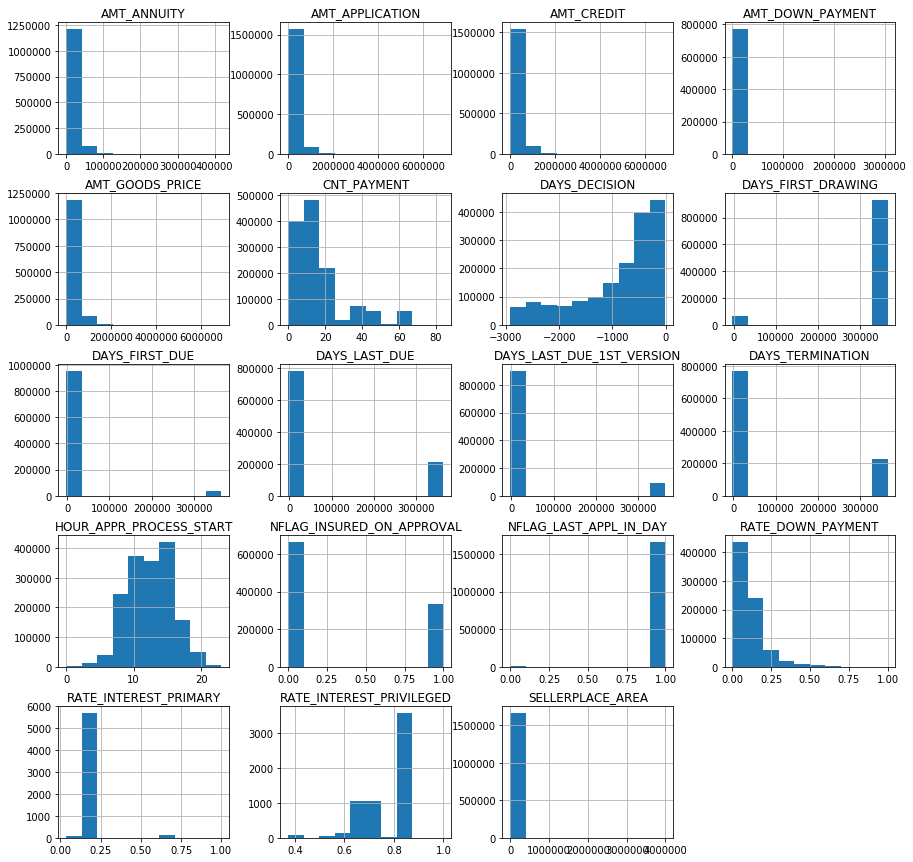

In [23]:
previous_application[pa_cont_feat].hist(figsize=(15,15))

In [24]:
previous_application[pa_cont_feat].describe()

,AMT_ANNUITY,AMT_APPLICATION,AMT_CREDIT,AMT_DOWN_PAYMENT,AMT_GOODS_PRICE,HOUR_APPR_PROCESS_START,NFLAG_LAST_APPL_IN_DAY,RATE_DOWN_PAYMENT,RATE_INTEREST_PRIMARY,RATE_INTEREST_PRIVILEGED,DAYS_DECISION,SELLERPLACE_AREA,CNT_PAYMENT,DAYS_FIRST_DRAWING,DAYS_FIRST_DUE,DAYS_LAST_DUE_1ST_VERSION,DAYS_LAST_DUE,DAYS_TERMINATION,NFLAG_INSURED_ON_APPROVAL
count,1297979.0000,1670214.0000,1670213.0000,774370.0000,1284699.0000,1670214.0000,1670214.0000,774370.0000,5951.0000,5951.0000,1670214.0000,1670214.0000,1297984.0000,997149.0000,997149.0000,997149.0000,997149.0000,997149.0000,997149.0000
mean,15955.1207,175233.8604,196114.0212,6697.4021,227847.2793,12.4842,0.9965,0.0796,0.1884,0.7735,-880.6797,313.9511,16.0541,342209.8550,13826.2693,33767.7741,76582.4031,81992.3438,0.3326
std,14782.1373,292779.7624,318574.6165,20921.4954,315396.5579,3.3340,0.0593,0.1078,0.0877,0.1009,779.0997,7127.4435,14.5673,88916.1158,72444.8697,106857.0348,149647.4151,153303.5167,0.4711
min,0.0000,0.0000,0.0000,-0.9000,0.0000,0.0000,0.0000,-0.0000,0.0348,0.3732,-2922.0000,-1.0000,0.0000,-2922.0000,-2892.0000,-2801.0000,-2889.0000,-2874.0000,0.0000
25%,6321.7800,18720.0000,24160.5000,0.0000,50841.0000,10.0000,1.0000,0.0000,0.1607,0.7156,-1300.0000,-1.0000,6.0000,365243.0000,-1628.0000,-1242.0000,-1314.0000,-1270.0000,0.0000
50%,11250.0000,71046.0000,80541.0000,1638.0000,112320.0000,12.0000,1.0000,0.0516,0.1891,0.8351,-581.0000,3.0000,12.0000,365243.0000,-831.0000,-361.0000,-537.0000,-499.0000,0.0000
75%,20658.4200,180360.0000,216418.5000,7740.0000,234000.0000,15.0000,1.0000,0.1089,0.1933,0.8525,-280.0000,82.0000,24.0000,365243.0000,-411.0000,129.0000,-74.0000,-44.0000,1.0000
max,418058.1450,6905160.0000,6905160.0000,3060045.0000,6905160.0000,23.0000,1.0000,1.0000,1.0000,1.0000,-1.0000,4000000.0000,84.0000,365243.0000,365243.0000,365243.0000,365243.0000,365243.0000,1.0000


In [25]:
previous_application[pa_other_feat].describe()

,NAME_CONTRACT_TYPE,WEEKDAY_APPR_PROCESS_START,FLAG_LAST_APPL_PER_CONTRACT,NAME_CASH_LOAN_PURPOSE,NAME_CONTRACT_STATUS,NAME_PAYMENT_TYPE,CODE_REJECT_REASON,NAME_TYPE_SUITE,NAME_CLIENT_TYPE,NAME_GOODS_CATEGORY,NAME_PORTFOLIO,NAME_PRODUCT_TYPE,CHANNEL_TYPE,NAME_SELLER_INDUSTRY,NAME_YIELD_GROUP,PRODUCT_COMBINATION
count,1670214,1670214,1670214,1670214,1670214,1670214,1670214,849809,1670214,1670214,1670214,1670214,1670214,1670214,1670214,1669868
unique,4,7,2,25,4,4,9,7,4,28,5,3,8,11,5,17
top,Cash loans,TUESDAY,Y,XAP,Approved,Cash through the bank,XAP,Unaccompanied,Repeater,XNA,POS,XNA,Credit and cash offices,XNA,XNA,Cash
freq,747553,255118,1661739,922661,1036781,1033552,1353093,508970,1231261,950809,691011,1063666,719968,855720,517215,285990


### Instalment_payments.csv

In [28]:
print installments_payments.shape
installments_payments.head()

(13605401, 8)


,SK_ID_PREV,SK_ID_CURR,NUM_INSTALMENT_VERSION,NUM_INSTALMENT_NUMBER,DAYS_INSTALMENT,DAYS_ENTRY_PAYMENT,AMT_INSTALMENT,AMT_PAYMENT
0,1054186,161674,1.0000,6,-1180.0000,-1187.0000,6948.3600,6948.3600
1,1330831,151639,0.0000,34,-2156.0000,-2156.0000,1716.5250,1716.5250
2,2085231,193053,2.0000,1,-63.0000,-63.0000,25425.0000,25425.0000
3,2452527,199697,1.0000,3,-2418.0000,-2426.0000,24350.1300,24350.1300
4,2714724,167756,1.0000,2,-1383.0000,-1366.0000,2165.0400,2160.5850


In [29]:
installments_payments[installments_payments.columns[2:]].describe()

,NUM_INSTALMENT_VERSION,NUM_INSTALMENT_NUMBER,DAYS_INSTALMENT,DAYS_ENTRY_PAYMENT,AMT_INSTALMENT,AMT_PAYMENT
count,13605401.0000,13605401.0000,13605401.0000,13602496.0000,13605401.0000,13602496.0000
mean,0.8566,18.8709,-1042.2700,-1051.1137,17050.9070,17238.2232
std,1.0352,26.6641,800.9463,800.5859,50570.2544,54735.7840
min,0.0000,1.0000,-2922.0000,-4921.0000,0.0000,0.0000
25%,0.0000,4.0000,-1654.0000,-1662.0000,4226.0850,3398.2650
50%,1.0000,8.0000,-818.0000,-827.0000,8884.0800,8125.5150
75%,1.0000,19.0000,-361.0000,-370.0000,16710.2100,16108.4250
max,178.0000,277.0000,-1.0000,-1.0000,3771487.8450,3771487.8450


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fcc68618590>,
      dtype=object)

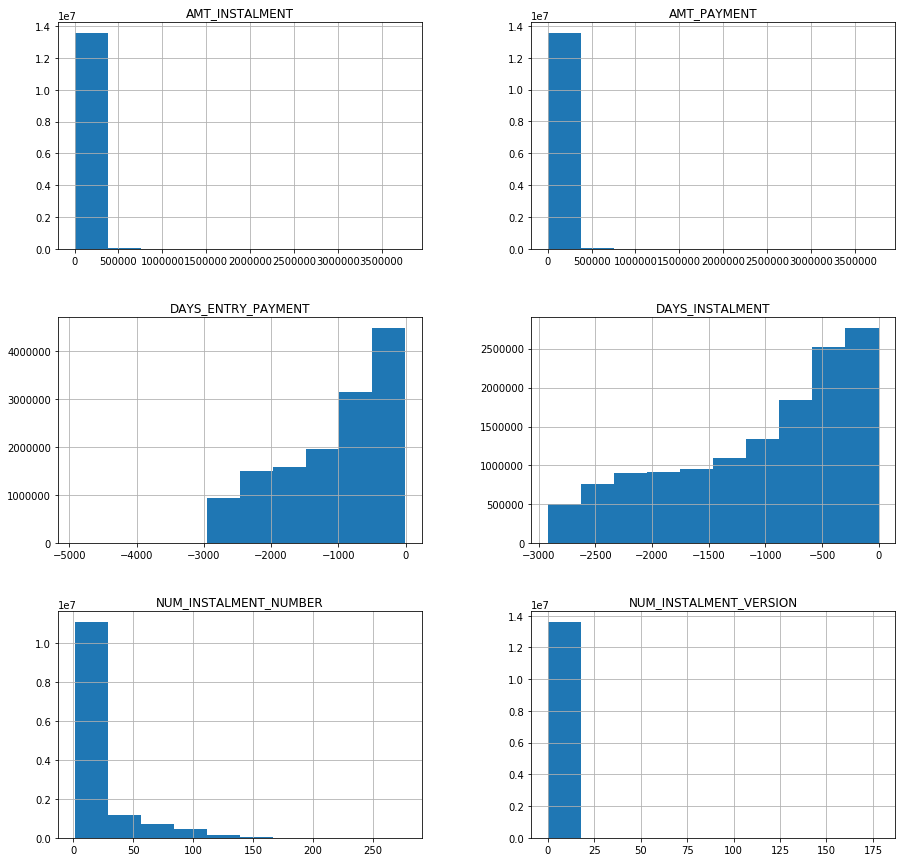

In [31]:
installments_payments[installments_payments.columns[2:]].hist(figsize=(15,15))

### credit_card_balance.csv

In [33]:
print credit_card_balance.shape
credit_card_balance.head()

(3840312, 23)


,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,AMT_BALANCE,AMT_CREDIT_LIMIT_ACTUAL,AMT_DRAWINGS_ATM_CURRENT,AMT_DRAWINGS_CURRENT,AMT_DRAWINGS_OTHER_CURRENT,AMT_DRAWINGS_POS_CURRENT,AMT_INST_MIN_REGULARITY,...,AMT_RECIVABLE,AMT_TOTAL_RECEIVABLE,CNT_DRAWINGS_ATM_CURRENT,CNT_DRAWINGS_CURRENT,CNT_DRAWINGS_OTHER_CURRENT,CNT_DRAWINGS_POS_CURRENT,CNT_INSTALMENT_MATURE_CUM,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF
0,2562384,378907,-6,56.9700,135000,0.0000,877.5000,0.0000,877.5000,1700.3250,...,0.0000,0.0000,0.0000,1,0.0000,1.0000,35.0000,Active,0,0
1,2582071,363914,-1,63975.5550,45000,2250.0000,2250.0000,0.0000,0.0000,2250.0000,...,64875.5550,64875.5550,1.0000,1,0.0000,0.0000,69.0000,Active,0,0
2,1740877,371185,-7,31815.2250,450000,0.0000,0.0000,0.0000,0.0000,2250.0000,...,31460.0850,31460.0850,0.0000,0,0.0000,0.0000,30.0000,Active,0,0
3,1389973,337855,-4,236572.1100,225000,2250.0000,2250.0000,0.0000,0.0000,11795.7600,...,233048.9700,233048.9700,1.0000,1,0.0000,0.0000,10.0000,Active,0,0
4,1891521,126868,-1,453919.4550,450000,0.0000,11547.0000,0.0000,11547.0000,22924.8900,...,453919.4550,453919.4550,0.0000,1,0.0000,1.0000,101.0000,Active,0,0


In [34]:
credit_card_balance.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3840312 entries, 0 to 3840311
Data columns (total 23 columns):
SK_ID_PREV                    int64
SK_ID_CURR                    int64
MONTHS_BALANCE                int64
AMT_BALANCE                   float64
AMT_CREDIT_LIMIT_ACTUAL       int64
AMT_DRAWINGS_ATM_CURRENT      float64
AMT_DRAWINGS_CURRENT          float64
AMT_DRAWINGS_OTHER_CURRENT    float64
AMT_DRAWINGS_POS_CURRENT      float64
AMT_INST_MIN_REGULARITY       float64
AMT_PAYMENT_CURRENT           float64
AMT_PAYMENT_TOTAL_CURRENT     float64
AMT_RECEIVABLE_PRINCIPAL      float64
AMT_RECIVABLE                 float64
AMT_TOTAL_RECEIVABLE          float64
CNT_DRAWINGS_ATM_CURRENT      float64
CNT_DRAWINGS_CURRENT          int64
CNT_DRAWINGS_OTHER_CURRENT    float64
CNT_DRAWINGS_POS_CURRENT      float64
CNT_INSTALMENT_MATURE_CUM     float64
NAME_CONTRACT_STATUS          object
SK_DPD                        int64
SK_DPD_DEF                    int64
dtypes: float64(15), int64(7

In [36]:
credit_card_balance[credit_card_balance.columns[2:20]].describe()

,MONTHS_BALANCE,AMT_BALANCE,AMT_CREDIT_LIMIT_ACTUAL,AMT_DRAWINGS_ATM_CURRENT,AMT_DRAWINGS_CURRENT,AMT_DRAWINGS_OTHER_CURRENT,AMT_DRAWINGS_POS_CURRENT,AMT_INST_MIN_REGULARITY,AMT_PAYMENT_CURRENT,AMT_PAYMENT_TOTAL_CURRENT,AMT_RECEIVABLE_PRINCIPAL,AMT_RECIVABLE,AMT_TOTAL_RECEIVABLE,CNT_DRAWINGS_ATM_CURRENT,CNT_DRAWINGS_CURRENT,CNT_DRAWINGS_OTHER_CURRENT,CNT_DRAWINGS_POS_CURRENT,CNT_INSTALMENT_MATURE_CUM
count,3840312.0000,3840312.0000,3840312.0000,3090496.0000,3840312.0000,3090496.0000,3090496.0000,3535076.0000,3072324.0000,3840312.0000,3840312.0000,3840312.0000,3840312.0000,3090496.0000,3840312.0000,3090496.0000,3090496.0000,3535076.0000
mean,-34.5219,58300.1553,153807.9574,5961.3248,7433.3882,288.1696,2968.8048,3540.2041,10280.5377,7588.8567,55965.8769,58088.8112,58098.2855,0.3094,0.7031,0.0048,0.5595,20.8251
std,26.6678,106307.0310,165145.6995,28225.6886,33846.0773,8201.9893,20796.8870,5600.1541,36078.0850,32005.9878,102533.6168,105965.3699,105971.8011,1.1004,3.1903,0.0826,3.2406,20.0515
min,-96.0000,-420250.1850,0.0000,-6827.3100,-6211.6200,0.0000,0.0000,0.0000,0.0000,0.0000,-423305.8200,-420250.1850,-420250.1850,0.0000,0.0000,0.0000,0.0000,0.0000
25%,-55.0000,0.0000,45000.0000,0.0000,0.0000,0.0000,0.0000,0.0000,152.3700,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,4.0000
50%,-28.0000,0.0000,112500.0000,0.0000,0.0000,0.0000,0.0000,0.0000,2702.7000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,15.0000
75%,-11.0000,89046.6862,180000.0000,0.0000,0.0000,0.0000,0.0000,6633.9112,9000.0000,6750.0000,85359.2400,88899.4912,88914.5100,0.0000,0.0000,0.0000,0.0000,32.0000
max,-1.0000,1505902.1850,1350000.0000,2115000.0000,2287098.3150,1529847.0000,2239274.1600,202882.0050,4289207.4450,4278315.6900,1472316.7950,1493338.1850,1493338.1850,51.0000,165.0000,12.0000,165.0000,120.0000


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fcc682afe90>,
      dtype=object)

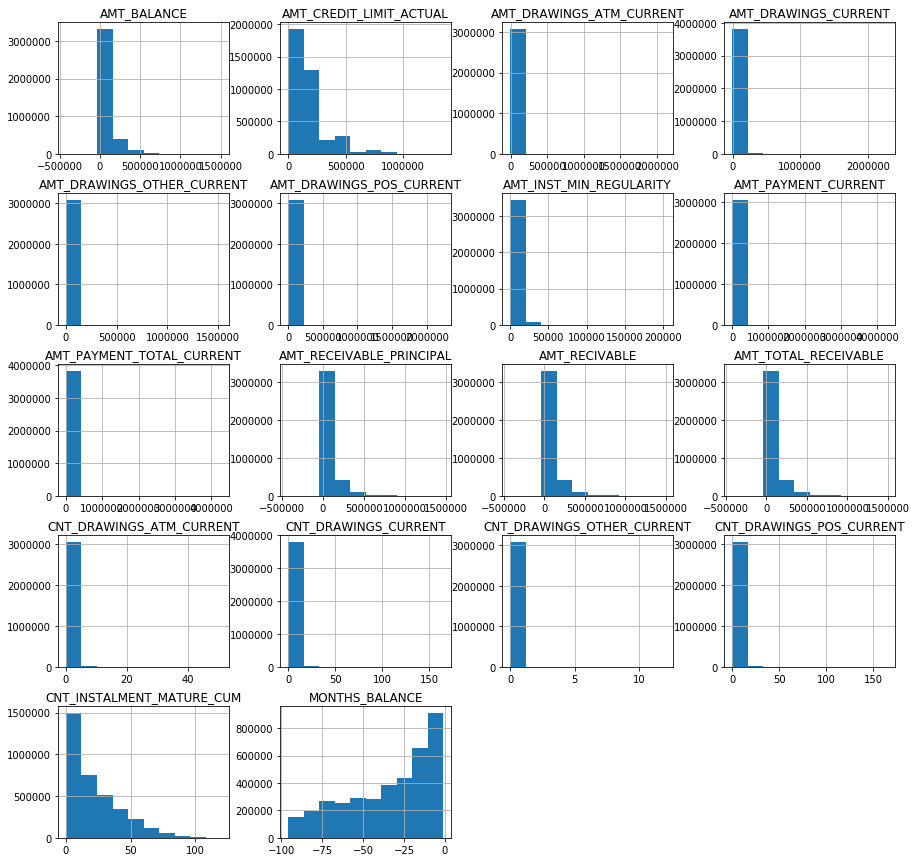

In [38]:
credit_card_balance[credit_card_balance.columns[2:20]].hist(figsize=(15,15) )

In [41]:
print credit_card_balance['NAME_CONTRACT_STATUS'].unique()
credit_card_balance['NAME_CONTRACT_STATUS'].describe()

['Active' 'Completed' 'Demand' 'Signed' 'Sent proposal' 'Refused'
 'Approved']


count     3840312
unique          7
top        Active
freq      3698436
Name: NAME_CONTRACT_STATUS, dtype: object

### POS_CASH_balance.csv

In [43]:
print POS_CASH_balance.shape
POS_CASH_balance.head()

(10001358, 8)


,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,CNT_INSTALMENT,CNT_INSTALMENT_FUTURE,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF
0,1803195,182943,-31,48.0000,45.0000,Active,0,0
1,1715348,367990,-33,36.0000,35.0000,Active,0,0
2,1784872,397406,-32,12.0000,9.0000,Active,0,0
3,1903291,269225,-35,48.0000,42.0000,Active,0,0
4,2341044,334279,-35,36.0000,35.0000,Active,0,0


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fcc5e928ad0>,
      dtype=object)

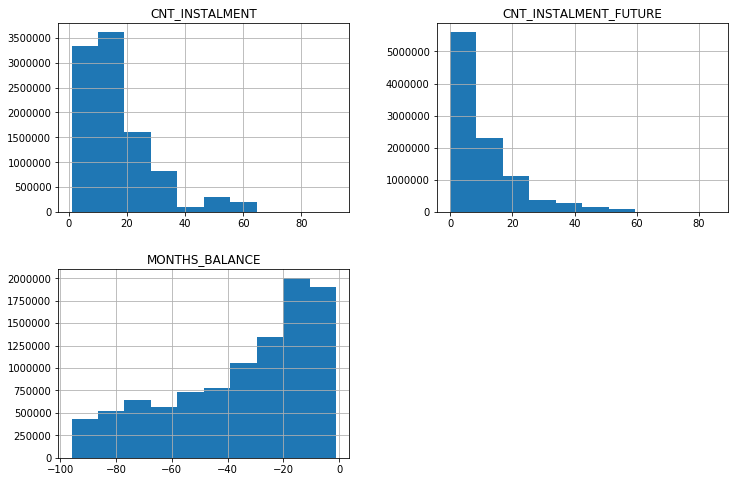

In [47]:
POS_CASH_balance[POS_CASH_balance.columns[2:5]].hist(figsize=(12,8))

In [49]:
print POS_CASH_balance['NAME_CONTRACT_STATUS'].unique()
POS_CASH_balance['NAME_CONTRACT_STATUS'].describe()

['Active' 'Completed' 'Signed' 'Approved' 'Returned to the store' 'Demand'
 'Canceled' 'XNA' 'Amortized debt']


count     10001358
unique           9
top         Active
freq       9151119
Name: NAME_CONTRACT_STATUS, dtype: object